In [1]:
import sys
# For data
sys.path.append('/afs/inf.ed.ac.uk/user/s13/s1301730/Documents/discriminitive_turns_project/discriminative_turns/')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Global imports
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [4]:
# Local imports 
from conversational_corpus import *

In [5]:
# Load the corpus data
with open( "/disk/scratch/swallbridge/pickles/swb_corpus.p", 'rb' ) as fp:
    swb_corpus = pickle.load(fp)
a = swb_corpus.load_speaker_turns(transcript_clean_fn=clean_transcript_swbc)
    
# with open( "/disk/scratch/swallbridge/pickles/fe_corpus_acceptable_utter_responses.p", "rb" ) as fp:
#     fe_corpus = pickle.load(fp)

## Characterize the datasets

In [6]:
# Does the corpus object contain acceptable utterances/turns? Only utterances but not turns...
# len(swb_corpus.conv_utter_responses), len(swb_corpus.conv_responses)
# (43977, 0)

In [8]:
# Some basic stats
print('FISHER')
print(f'conversations       : {len(fe_corpus.conversations)}')
print(f'conv_utter_responses: {len(fe_corpus.conv_utter_responses)}')
print(f'conv_utters         : {len(fe_corpus.conv_utters)}')
print(f'conv_responses      : {len(fe_corpus.conv_responses)}')
print(f'conv_turns          : {len(fe_corpus.conv_turns)}')
# print(f'unique tokens       : {len(fe_tok_c)}')
# print(f'total tokens        : {sum(fe_tok_c.values())}')

print('\nSWB')
print(f'conversations       : {len(swb_corpus.conversations)}')
print(f'conv_utter_responses: {len(swb_corpus.conv_utter_responses)}')
print(f'conv_utters         : {len(swb_corpus.conv_utters)}')
print(f'conv_responses      : {len(swb_corpus.conv_responses)}')
print(f'conv_turns          : {len(swb_corpus.conv_turns)}')
# print(f'unique tokens       : {len(swb_tok_c)}')
# print(f'total tokens        : {sum(swb_tok_c.values())}')

FISHER


NameError: name 'fe_corpus' is not defined

In [6]:
# Count turns per conversation
swb_turn_df = pd.DataFrame(swb_corpus.conv_turns)
# fe_turn_df = pd.DataFrame(fe_corpus.conv_turns)

In [ ]:
# Plot turns per conversation
swb_turn_lengths = list(swb_turn_df['conv_id'].value_counts())
fe_turn_lengths = list(fe_turn_df['conv_id'].value_counts())

f, ax = plt.subplots(1,1,figsize=(10,6))
ax.hist(fe_turn_lengths, label=f'Fisher ({np.mean(fe_turn_lengths):.2f})', color='C0', alpha=0.7)
ax.hist(swb_turn_lengths, label=f'SWB    ({np.mean(swb_turn_lengths):.2f})', color='C1', alpha=0.7)

ax.axvline(np.mean(fe_turn_lengths), color='C0')
ax.axvline(np.mean(swb_turn_lengths),  color='C1')

ax.set_xlabel('Turns per conversation')
ax.legend()


## Consider some cleaning...
TODO; didn't finish this. The cleaning is not standardized between the 2 datasets

In [7]:
print("Empty 'cleaned' turns")
print(f" - SWB: {sum([1 for t in swb_corpus.conv_turns if len(t['clean_text']) < 1]) / len(swb_corpus.conv_turns) * 100:.1f}%")
print(f" - FE : {sum([1 for t in fe_corpus.conv_turns if len(t['clean_text']) < 1]) / len(fe_corpus.conv_turns) * 100:.1f}%")

print("Empty 'cleaned' utterances")
print(f" - SWB: {sum([1 for t in swb_corpus.conv_utters if len(t['clean_text']) < 1]) / len(swb_corpus.conv_utters) * 100:.1f}%")
print(f" - FE : {sum([1 for t in fe_corpus.conv_utters if len(t['clean_text']) < 1]) / len(fe_corpus.conv_utters) * 100:.1f}%")


Empty 'cleaned' turns
 - SWB: 3.6%


NameError: name 'fe_corpus' is not defined

In [8]:
# m=20
# mm=50
[c['clean_text'] for c in swb_corpus.conv_turns if 'um-hum' in c['clean_text']][:5]

['um-hum all right', 'um-hum', 'uh-huh um-hum', 'um-hum', 'um-hum']

In [9]:
# [c['clean_text'] for c in fe_corpus.conv_turns if 'huh' in c['clean_text']]

## Make a swb_corpus object based on TTD
TTD uses slightly different turn segmentation, which I think will make the audio experiments easier. In the original SWB dataset, utterances seem to be sorted based on their start times, however this makes catching overlap really hard. TTD builds turns using word time stamps. These are joined into IPUs, where frame sequences of overlaps are removed if they are surrounded by mutual silences.

Therefore, I will use this method of segmenting turns -- to make the audio experiments easier, I will convert the TTD turn segmentations into a corpus object (only needs to contain conv_turns) which I can pickle, and load appropriately.

In [10]:
# What attributes are needed
# {'conv_id': 'sw03489', # needed
#  'speaker': ['A'], # needed: this can be a single instance!
#  'turn_id': 0, # needed: ??
#  'utter_ids': [0],
#  'all_times': [array([0., 8.487625])], 
#  'start': 0.0, # needed
#  'stop': 8.487625, # needed
#  'texts': ["[noise] -[o",
#  'text': "[noise] -[o]kay",
#  'clean_text': "okay Jerry i" # needed
# }


In [39]:
from glob import glob
import json
from tqdm.notebook import tqdm

# from ttd_utils
def read_json(path, encoding="utf8"):
    with open(path, "r", encoding=encoding) as f:
        data = json.loads(f.read())
    return data

speaker_channel = {0: 'A', 1: 'B'}

def convert_turns_into_objects(turns, conv_id):
    new_turns = []
    for i, t in enumerate(turns):
        new_turn = {
            'conv_id': 'sw0' + conv_id[-4:],
            'speaker': speaker_channel[t['speaker_id']],
            'turn_id': i, 
            'start': t['starts'][0],
            'stop': t['ends'][-1],
            'clean_text': t['text'],
        }
        new_turns.append(new_turn)
    return new_turns


In [45]:
# For Word-Time-Stamp (wts) turns
wts_path = '/disk/scratch/swallbridge/TurnGPT/data/switchboard/dialogs_turn_level'
wts_files = glob(wts_path + '/*')

wts_dialogues = {}
wts_turns = []
for file in tqdm(wts_files):
    conv_id = file.split('/')[-1][:-5]
    
    turns = read_json(file)
    new_turns = convert_turns_into_objects(turns, conv_id)
    wts_turns.extend(new_turns)

  0%|          | 0/2435 [00:00<?, ?it/s]

In [41]:
# For VAD turns (original TTD version)
ttd_path = '/disk/scratch/swallbridge/TurnGPT/data/switchboard_vad/dialogs_turn_level'
ttd_files = glob(vad_path + '/*')

ttd_dialogues = {}
ttd_turns = []
for file in tqdm(ttd_files):
    conv_id = file.split('/')[-1][:-5]
    
    turns = read_json(file)
    new_turns = convert_turns_into_objects(turns, conv_id)
    ttd_turns.extend(new_turns)

  0%|          | 0/2435 [00:00<?, ?it/s]

In [42]:
[t for t in ttd_turns if t['clean_text'] == '']

[]

In [46]:
from conversational_corpus import ConversationTranscripts
ttd_corpus = ConversationTranscripts(transcripts_path=None, conversation_fn=None, conv_num=len(ttd_dialogues))
ttd_corpus.conv_turns = ttd_turns

wts_corpus = ConversationTranscripts(transcripts_path=None, conversation_fn=None, conv_num=len(vad_dialogues))
wts_corpus.conv_turns = wts_turns


In [67]:
# with open('/disk/scratch/swallbridge/pickles/ttd_corpus.p', 'wb') as fp:
#     pickle.dump(ttd_corpus, fp)

with open('/disk/scratch/swallbridge/pickles/wts_corpus.p', 'wb') as fp:
    pickle.dump(wts_corpus, fp)

180337 106597 188033


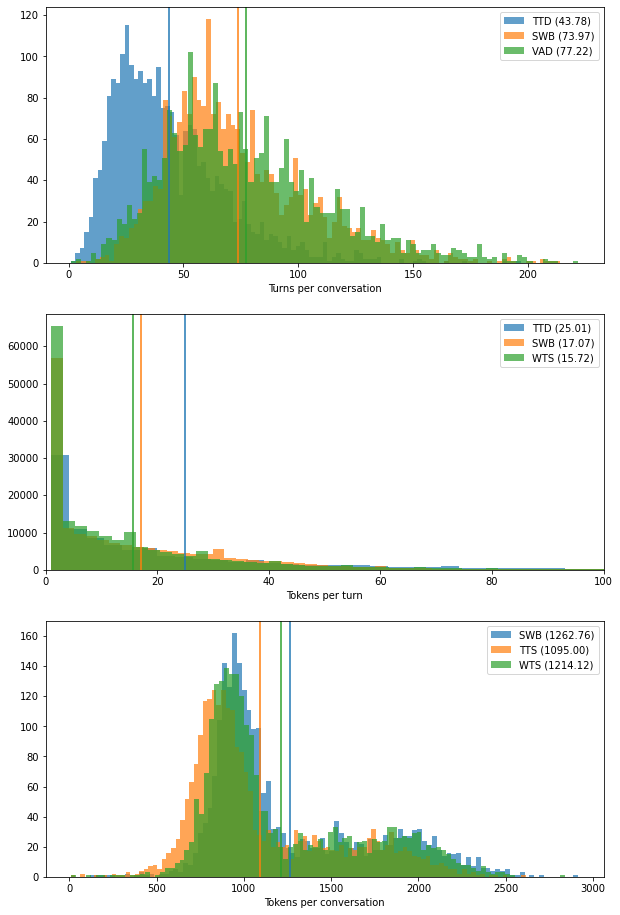

In [75]:
print(len(swb_corpus.conv_turns), len(ttd_corpus.conv_turns), len(wts_corpus.conv_turns))
swb_turn_df = pd.DataFrame(swb_corpus.conv_turns)
ttd_turn_df = pd.DataFrame(ttd_corpus.conv_turns)
wts_turn_df = pd.DataFrame(wts_corpus.conv_turns)

Plot turns per conversation
swb_turn_lengths = list(swb_turn_df['conv_id'].value_counts())
ttd_turn_lengths = list(ttd_turn_df['conv_id'].value_counts())
wts_turn_lengths = list(wts_turn_df['conv_id'].value_counts())

f, ax = plt.subplots(3,1,figsize=(10,16))
ax[0].hist(ttd_turn_lengths, label=f'TTD ({np.mean(ttd_turn_lengths):.2f})', color='C0', alpha=0.7, bins=100)
ax[0].hist(swb_turn_lengths, label=f'SWB ({np.mean(swb_turn_lengths):.2f})', color='C1', alpha=0.7, bins=100)
ax[0].hist(wts_turn_lengths, label=f'VAD ({np.mean(wts_turn_lengths):.2f})', color='C2', alpha=0.7, bins=100)

ax[0].axvline(np.mean(ttd_turn_lengths), color='C0')
ax[0].axvline(np.mean(swb_turn_lengths),  color='C1')
ax[0].axvline(np.mean(wts_turn_lengths),  color='C2')

ax[0].set_xlabel('Turns per conversation')
ax[0].legend()

Plot tokens per turn
swb_tok_lengths = [len(t.split(' ')) for t in list(swb_turn_df['clean_text'])]
ttd_tok_lengths = [len(t.split(' ')) for t in list(ttd_turn_df['clean_text'])]
wts_tok_lengths = [len(t.split(' ')) for t in list(wts_turn_df['clean_text'])]

# f, ax = plt.subplots(1,1,figsize=(10,6))
ax[1].hist(ttd_tok_lengths, label=f'TTD ({np.mean(ttd_tok_lengths):.2f})', color='C0', alpha=0.7, bins=200)
ax[1].hist(swb_tok_lengths, label=f'SWB ({np.mean(swb_tok_lengths):.2f})', color='C1', alpha=0.7, bins=200)
ax[1].hist(wts_tok_lengths, label=f'WTS ({np.mean(wts_tok_lengths):.2f})', color='C2', alpha=0.7, bins=200)

ax[1].axvline(np.mean(ttd_tok_lengths), color='C0')
ax[1].axvline(np.mean(swb_tok_lengths),  color='C1')
ax[1].axvline(np.mean(wts_tok_lengths),  color='C2')

ax[1].set_xlim(0,100)

ax[1].set_xlabel('Tokens per turn')
ax[1].legend()


Plot tokens per turn
swb_c_ids = set(list(swb_turn_df.conv_id))
swb_tok_convs = [sum([len(t.split(' ')) for t in list(swb_turn_df[swb_turn_df.conv_id == c]['clean_text'])]) for c in tqdm(swb_c_ids)]
ttd_c_ids = set(list(ttd_turn_df.conv_id))
ttd_tok_convs = [sum([len(t.split(' ')) for t in list(ttd_turn_df[ttd_turn_df.conv_id == c]['clean_text'])]) for c in tqdm(ttd_c_ids)]
wts_c_ids = set(list(wts_turn_df.conv_id))
wts_tok_convs = [sum([len(t.split(' ')) for t in list(wts_turn_df[wts_turn_df.conv_id == c]['clean_text'])]) for c in tqdm(wts_c_ids)]

ax[2].hist(swb_tok_convs, label=f'SWB ({np.mean(swb_tok_convs):.2f})', color='C0', alpha=0.7, bins=100)
ax[2].hist(ttd_tok_convs, label=f'TTS ({np.mean(ttd_tok_convs):.2f})', color='C1', alpha=0.7, bins=100)
ax[2].hist(wts_tok_convs, label=f'WTS ({np.mean(wts_tok_convs):.2f})', color='C2', alpha=0.7, bins=100)

ax[2].axvline(np.mean(swb_tok_convs), color='C0')
ax[2].axvline(np.mean(ttd_tok_convs),  color='C1')
ax[2].axvline(np.mean(wts_tok_convs),  color='C2')

ax[2].set_xlabel('Tokens per conversation')
ax[2].legend()


## Making datasets for Post Training `BERT-FP`

In [52]:
# Get the turns per conversation 
swb_conv_turns = swb_turn_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
# fe_conv_turns = fe_turn_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
ttd_conv_turns = ttd_turn_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
wts_conv_turns = wts_turn_df.groupby('conv_id')['clean_text'].apply(list).to_dict()


In [53]:
# Split conversation ids into train, test, val (and small train)
from sklearn.model_selection import train_test_split
swb_train, swb_testing = train_test_split(list(swb_conv_turns.keys()), test_size=0.2, random_state=1)
swb_val, swb_test = train_test_split(swb_testing, test_size=0.5, random_state=1)
_, swb_train_small = train_test_split(swb_train, test_size=0.005, random_state=1)

# Split conversation ids into train, test, val based on NXT labels
da_path = '/group/project/cstr1/mscslp/2019-20/clai/switchboard/trans_all'
nxt_files = glob (da_path + '/*')
nxt_conv_ids = ['sw0' + f.split('/')[-1][2:6] for f in nxt_files]
print(f'Number of nxt files: {len(nxt_files)}')

swb_train_nxt = [t for t in set(list(swb_turn_df.conv_id)) if t not in nxt_conv_ids]
swb_val_nxt, swb_test_nxt = train_test_split(nxt_conv_ids, test_size=0.5, random_state=1)

print(f'total files: {len(swb_train_nxt) + len(swb_val_nxt)+ len(swb_test_nxt)}')
print(f'train files: {len(swb_train_nxt)/len(set(list(swb_turn_df.conv_id))):.3f}% ({len(swb_train_nxt)})')
print(f'valid files: {len(swb_val_nxt)/len(set(list(swb_turn_df.conv_id))):.3f}% ({len(swb_val_nxt)})')
print(f'test  files: {len(swb_test_nxt)/len(set(list(swb_turn_df.conv_id))):.3f}% ({len(swb_test_nxt)})')

Number of nxt files: 642
total files: 2438
train files: 0.737% (1796)
valid files: 0.132% (321)
test  files: 0.132% (321)


In [54]:
# NOTE: switch the set of conv_ids to random splits (swb_train) or based on nxt (swb_train_nxt)

# Count turns per conversation
# swb_train_small_df = swb_turn_df[swb_turn_df.conv_id.isin(swb_train_small)]
swb_train_df = swb_turn_df[swb_turn_df.conv_id.isin(swb_train_nxt)]
swb_val_df = swb_turn_df[swb_turn_df.conv_id.isin(swb_val_nxt)]
swb_test_df = swb_turn_df[swb_turn_df.conv_id.isin(swb_test_nxt)]

# ttd_train_small_df = ttd_turn_df[ttd_turn_df.conv_id.isin(swb_train_small)]
ttd_train_df = ttd_turn_df[ttd_turn_df.conv_id.isin(swb_train_nxt)]
ttd_val_df = ttd_turn_df[ttd_turn_df.conv_id.isin(swb_val_nxt)]
ttd_test_df = ttd_turn_df[ttd_turn_df.conv_id.isin(swb_test_nxt)]

wts_train_df = wts_turn_df[wts_turn_df.conv_id.isin(swb_train_nxt)]
wts_val_df = wts_turn_df[wts_turn_df.conv_id.isin(swb_val_nxt)]
wts_test_df = wts_turn_df[wts_turn_df.conv_id.isin(swb_test_nxt)]

Text(0.5, 0, 'Turns per conversation')

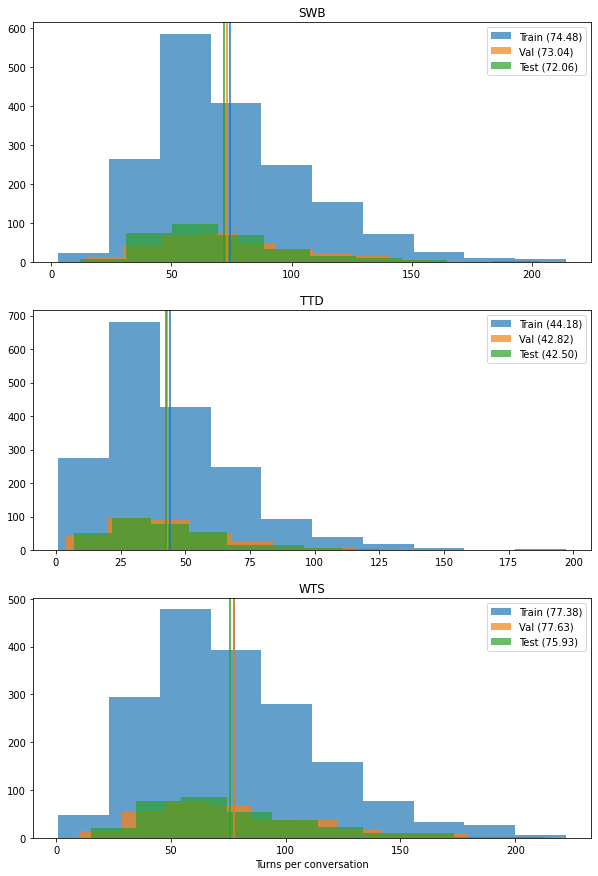

In [55]:
# Plot turns per conversation in the different splits
swb_train_lengths = list(swb_train_df['conv_id'].value_counts())
swb_val_lengths = list(swb_val_df['conv_id'].value_counts())
swb_test_lengths = list(swb_test_df['conv_id'].value_counts())

ttd_train_lengths = list(ttd_train_df['conv_id'].value_counts())
ttd_val_lengths = list(ttd_val_df['conv_id'].value_counts())
ttd_test_lengths = list(ttd_test_df['conv_id'].value_counts())

wts_train_lengths = list(wts_train_df['conv_id'].value_counts())
wts_val_lengths = list(wts_val_df['conv_id'].value_counts())
wts_test_lengths = list(wts_test_df['conv_id'].value_counts())

f, ax = plt.subplots(3,1,figsize=(10,15))
ax[0].hist(swb_train_lengths, label=f'Train ({np.mean(swb_train_lengths):.2f})', color='C0', alpha=0.7)
ax[0].hist(swb_val_lengths, label=f'Val ({np.mean(swb_val_lengths):.2f})', color='C1', alpha=0.7)
ax[0].hist(swb_test_lengths, label=f'Test ({np.mean(swb_test_lengths):.2f})', color='C2', alpha=0.7)

ax[0].axvline(np.mean(swb_train_lengths), color='C0')
ax[0].axvline(np.mean(swb_val_lengths), color='C1')
ax[0].axvline(np.mean(swb_test_lengths), color='C2')

ax[0].set_title('SWB')
ax[0].legend()

ax[1].hist(ttd_train_lengths, label=f'Train ({np.mean(ttd_train_lengths):.2f})', color='C0', alpha=0.7)
ax[1].hist(ttd_val_lengths, label=f'Val ({np.mean(ttd_val_lengths):.2f})', color='C1', alpha=0.7)
ax[1].hist(ttd_test_lengths, label=f'Test ({np.mean(ttd_test_lengths):.2f})', color='C2', alpha=0.7)

ax[1].axvline(np.mean(ttd_train_lengths), color='C0')
ax[1].axvline(np.mean(ttd_val_lengths), color='C1')
ax[1].axvline(np.mean(ttd_test_lengths), color='C2')

ax[1].set_title('TTD')
ax[1].legend()

ax[2].hist(wts_train_lengths, label=f'Train ({np.mean(wts_train_lengths):.2f})', color='C0', alpha=0.7)
ax[2].hist(wts_val_lengths, label=f'Val ({np.mean(wts_val_lengths):.2f})', color='C1', alpha=0.7)
ax[2].hist(wts_test_lengths, label=f'Test ({np.mean(wts_test_lengths):.2f})', color='C2', alpha=0.7)

ax[2].axvline(np.mean(wts_train_lengths), color='C0')
ax[2].axvline(np.mean(wts_val_lengths), color='C1')
ax[2].axvline(np.mean(wts_test_lengths), color='C2')

ax[2].set_title('WTS')
ax[2].legend()
ax[2].set_xlabel('Turns per conversation')




In [33]:
# Write them as list of lists
# swb_train_small_dict = swb_train_small_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
swb_train_dict = swb_train_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
swb_val_dict = swb_val_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
swb_test_dict = swb_test_df.groupby('conv_id')['clean_text'].apply(list).to_dict()

# swb_train_small_turns = list(swb_train_small_dict.values())
swb_train_turns = list(swb_train_dict.values())
swb_val_turns = list(swb_val_dict.values())
swb_test_turns = list(swb_test_dict.values())

# with open('spoken_data/swb_train_small.pkl', 'wb') as fp:
#     pickle.dump(swb_train_small_turns, fp)
    
# with open('spoken_data/swb_train_nxt.pkl', 'wb') as fp:
#     pickle.dump(swb_train_turns, fp)
    
# with open('spoken_data/swb_val_nxt.pkl', 'wb') as fp:
#     pickle.dump(swb_val_turns, fp)
    
# with open('spoken_data/swb_test_nxt.pkl', 'wb') as fp:
#     pickle.dump(swb_test_turns, fp)

In [56]:
# Write them as list of lists
# swb_train_small_dict = swb_train_small_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
ttd_train_dict = ttd_train_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
ttd_val_dict = ttd_val_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
ttd_test_dict = ttd_test_df.groupby('conv_id')['clean_text'].apply(list).to_dict()

# swb_train_small_turns = list(swb_train_small_dict.values())
ttd_train_turns = list(ttd_train_dict.values())
ttd_val_turns = list(ttd_val_dict.values())
ttd_test_turns = list(ttd_test_dict.values())

# with open('spoken_data/ttd_train_small.pkl', 'wb') as fp:
#     pickle.dump(ttd_train_small_turns, fp)
    
# with open('spoken_data/ttd_train_nxt.pkl', 'wb') as fp:
#     pickle.dump(ttd_train_turns, fp)
    
# with open('spoken_data/ttd_val_nxt.pkl', 'wb') as fp:
#     pickle.dump(ttd_val_turns, fp)
    
# with open('spoken_data/ttd_test_nxt.pkl', 'wb') as fp:
#     pickle.dump(ttd_test_turns, fp)

In [58]:
# Write them as list of lists
# swb_train_small_dict = swb_train_small_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
wts_train_dict = wts_train_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
wts_val_dict = wts_val_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
wts_test_dict = wts_test_df.groupby('conv_id')['clean_text'].apply(list).to_dict()

# swb_train_small_turns = list(swb_train_small_dict.values())
wts_train_turns = list(wts_train_dict.values())
wts_val_turns = list(wts_val_dict.values())
wts_test_turns = list(wts_test_dict.values())

# with open('spoken_data/wts_train_small.pkl', 'wb') as fp:
#     pickle.dump(wts_train_small_turns, fp)
    
# with open('spoken_data/wts_train_nxt.pkl', 'wb') as fp:
#     pickle.dump(wts_train_turns, fp)
    
# with open('spoken_data/wts_val_nxt.pkl', 'wb') as fp:
#     pickle.dump(wts_val_turns, fp)
    
# with open('spoken_data/wts_test_nxt.pkl', 'wb') as fp:
#     pickle.dump(wts_test_turns, fp)

In [60]:
print(swb_val_turns[1][:8])
print(ttd_val_turns[1][:8])
print(wts_val_turns[1][:8])



['hello this is Lois', 'hello hi hi this is Lisa', 'and um i called you know from that the the TI Database Calling Instructions', 'um-hum yeah i got a call yesterday too this is a different subject though', 'yeah this is about changes in women in the', 'um-hum', "uh there's really a lot isn't there really is", "yeah -t's kind of an easy thing to talk about"]
['hello', 'hello is Lois', 'this is Lisa', 'um i called you know from that the the TI Database Calling Instructions', 'i got a call yesterday too this is a different subject though', "this is about changes in women in the there's really a lot isn't there i mean there really is", 'kind of an easy thing to talk about', "i guess the work force would be the main wouldn't it uh"]
['hello', 'hello', 'hi', 'this is Lois', 'hi this is Lisa', 'and um i called you know from that the the TI Database Calling Instructions', 'yeah i got a call yesterday too this is a different subject though', 'yeah this is about changes in women in the']


In [61]:
# Make full_info versions of the datasets (ie, where each turn contains its associated meta info)

# cols = ['conv''speaker', 'turn_id', 'utter_ids', 'all_times', 
#         'start', 'stop', 'texts', 'text', 'clean_text']

def make_meta_dataset(turns_df):
    """
    Instead of a list of turns, return a list of dicts (each dict is a turn object)
    """
    conv_ids = list(set(turns_df.conv_id))
    result = {}
    for cid in tqdm(conv_ids):
        cdf = turns_df.groupby('conv_id').get_group(cid)
        result[cid] = cdf.to_dict('records') #[cols].to_dict('records')
    return result


In [63]:
# For SWB corpus object...
# swb_train_small_info_dict = make_meta_dataset(swb_train_small_df)
swb_train_info_dict = make_meta_dataset(swb_train_df)
swb_val_info_dict = make_meta_dataset(swb_val_df)
swb_test_info_dict = make_meta_dataset(swb_test_df)

# swb_train_small_turns_info = list(swb_train_small_info_dict.values())
swb_train_turns_info = list(swb_train_info_dict.values())
swb_val_turns_info = list(swb_val_info_dict.values())
swb_test_turns_info = list(swb_test_info_dict.values())

  0%|          | 0/1796 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

In [64]:
# with open('spoken_data/swb_info_train_small.pkl', 'wb') as fp:
#     pickle.dump(swb_train_small_turns_info, fp)
    
# with open('spoken_data/swb_nxt_info_train.pkl', 'wb') as fp:
#     pickle.dump(swb_train_turns_info, fp)
    
# with open('spoken_data/swb_nxt__info_val.pkl', 'wb') as fp:
#     pickle.dump(swb_val_turns_info, fp)
    
# with open('spoken_data/swb_nxt_info_test.pkl', 'wb') as fp:
#     pickle.dump(swb_test_turns_info, fp)

In [56]:
# #### SANITY CHECK: is this reproducable?? YES.

# with open('spoken_data/swb_train_small.pkl', 'rb') as fp:
#     swb_train_small_reload = pickle.load(fp)
    
# with open('spoken_data/swb_train.pkl', 'rb') as fp:
#     swb_train_reload = pickle.load(fp)
    
# with open('spoken_data/swb_val.pkl', 'rb') as fp:
#     swb_val_reload = pickle.load(fp)
    
# with open('spoken_data/swb_test.pkl', 'rb') as fp:
#     swb_test_reload = pickle.load(fp)
    
# swb_train_small_reload == swb_train_small_turns

In [47]:
# Same for TTD corpus...
# ttd_train_small_info_dict = make_meta_dataset(ttd_train_small_df)
ttd_train_info_dict = make_meta_dataset(ttd_train_df)
ttd_val_info_dict = make_meta_dataset(ttd_val_df)
ttd_test_info_dict = make_meta_dataset(ttd_test_df)

# ttd_train_small_turns_info = list(ttd_train_small_info_dict.values())
ttd_train_turns_info = list(ttd_train_info_dict.values())
ttd_val_turns_info = list(ttd_val_info_dict.values())
ttd_test_turns_info = list(ttd_test_info_dict.values())

  0%|          | 0/1794 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

In [72]:
# ttd_val_turns[0]

In [62]:
# # Same for WTS corpus...
wts_train_info_dict = make_meta_dataset(wts_train_df)
wts_val_info_dict = make_meta_dataset(wts_val_df)
wts_test_info_dict = make_meta_dataset(wts_test_df)

wts_train_turns_info = list(wts_train_info_dict.values())
wts_val_turns_info = list(wts_val_info_dict.values())
wts_test_turns_info = list(wts_test_info_dict.values())

  0%|          | 0/1794 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

In [63]:
wts_test_turns_info[:3]

[[{'conv_id': 'sw04171',
   'speaker': 'A',
   'turn_id': 0,
   'start': 0.647375,
   'stop': 3.287375,
   'clean_text': 'so uh do you happen to be working for a large firm'},
  {'conv_id': 'sw04171',
   'speaker': 'B',
   'turn_id': 1,
   'start': 3.7925,
   'stop': 9.3825,
   'clean_text': "well it's about three hundred and fifty people i guess that's not large compared to some but it's big enough"},
  {'conv_id': 'sw04171',
   'speaker': 'A',
   'turn_id': 2,
   'start': 9.772,
   'stop': 10.152,
   'clean_text': 'mhm'},
  {'conv_id': 'sw04171',
   'speaker': 'B',
   'turn_id': 3,
   'start': 10.675,
   'stop': 16.130625,
   'clean_text': "and they have a they don't have any kind of pension plan where they contribute anything and i wish they did"},
  {'conv_id': 'sw04171',
   'speaker': 'A',
   'turn_id': 4,
   'start': 16.557125,
   'stop': 16.877125,
   'clean_text': 'yeah'},
  {'conv_id': 'sw04171',
   'speaker': 'B',
   'turn_id': 5,
   'start': 16.625125,
   'stop': 19.345125,


In [65]:
# with open('spoken_data/ttd_nxt_info_train_small.pkl', 'wb') as fp:
#     pickle.dump(ttd_train_small_turns_info, fp)
    
# with open('spoken_data/wts_nxt_info_train.pkl', 'wb') as fp:
#     pickle.dump(wts_train_turns_info, fp)
    
# with open('spoken_data/wts_nxt_info_val.pkl', 'wb') as fp:
#     pickle.dump(wts_val_turns_info, fp)
    
# with open('spoken_data/wts_nxt_info_test.pkl', 'wb') as fp:
#     pickle.dump(wts_test_turns_info, fp)

In [66]:
wts_test_turns_info[:3]

[[{'conv_id': 'sw04171',
   'speaker': 'A',
   'turn_id': 0,
   'start': 0.647375,
   'stop': 3.287375,
   'clean_text': 'so uh do you happen to be working for a large firm'},
  {'conv_id': 'sw04171',
   'speaker': 'B',
   'turn_id': 1,
   'start': 3.7925,
   'stop': 9.3825,
   'clean_text': "well it's about three hundred and fifty people i guess that's not large compared to some but it's big enough"},
  {'conv_id': 'sw04171',
   'speaker': 'A',
   'turn_id': 2,
   'start': 9.772,
   'stop': 10.152,
   'clean_text': 'mhm'},
  {'conv_id': 'sw04171',
   'speaker': 'B',
   'turn_id': 3,
   'start': 10.675,
   'stop': 16.130625,
   'clean_text': "and they have a they don't have any kind of pension plan where they contribute anything and i wish they did"},
  {'conv_id': 'sw04171',
   'speaker': 'A',
   'turn_id': 4,
   'start': 16.557125,
   'stop': 16.877125,
   'clean_text': 'yeah'},
  {'conv_id': 'sw04171',
   'speaker': 'B',
   'turn_id': 5,
   'start': 16.625125,
   'stop': 19.345125,


## Create the fine-tuning datasets
full and short-context versions (save each in eg. SWB_dataset_2409.pkl, v SWB_dataset_3923948.pkl)

In [23]:
from FPT.swb_final import BERTDataset, InputExample, convert_example_to_features
from transformers import BertTokenizer,BertConfig

11/08/2022 22:50:01 - INFO - FPT.swb_final -   CUDA info: device 0, name: GeForce GTX 1080 Ti


In [24]:
# Create the fine-tuning datasets
args = {
    'bert_model': 'bert-base-uncased', 
    'do_lower_case': True, 
    'gradient_accumulation_steps': 1, 
    'learning_rate': 1.5e-05, 
    'max_seq_length': 240, 
    'num_train_epochs': 25.0, 
    'output_dir': './FPT/PT_checkpoint/switchboard', 
    'train_batch_size': 8, 
    'train_file': './spoken_data/swb_train_small.pkl', 
    'warmup_proportion': 0.01
        }


tokenizer = BertTokenizer.from_pretrained(args['bert_model'], do_lower_case=args['do_lower_case'])

special_tokens_dict = {'eos_token': '[eos]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

#     bertconfig = BertConfig.from_pretrained(args.bert_model)
#     model = BertForPreTraining.from_pretrained(args.bert_model, config=bertconfig)

#     model.resize_token_embeddings(len(tokenizer))
#     model.cls.seq_relationship = nn.Linear(bertconfig.hidden_size, 3)
#     #load checkpoint here
#     #model.bert.load_state_dict(state_dict=torch.load("ubuntu_final/checkpoint20-1637300/bert.pt"))
#     model.to(device)

train_small_dataset = BERTDataset(args['train_file'], tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)
train_dataset = BERTDataset('./spoken_data/swb_train_nxt.pkl', tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)
val_dataset = BERTDataset('./spoken_data/swb_val_nxt.pkl', tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)
test_dataset = BERTDataset('./spoken_data/swb_test_nxt.pkl', tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)


11/08/2022 22:50:01 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /disk/scratch/swallbridge/BERT_FP/temp_cache/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
11/08/2022 22:50:01 - INFO - transformers.tokenization_utils -   Adding [eos] to the vocabulary
11/08/2022 22:50:01 - INFO - transformers.tokenization_utils -   Assigning [eos] to the eos_token key of the tokenizer
  3%|▎         | 56/1796 [00:00<00:03, 556.22it/s]

0 0


 21%|██        | 67/321 [00:00<00:00, 661.59it/s]

0 1


 21%|██▏       | 69/321 [00:00<00:00, 683.94it/s]

0 0


100%|██████████| 321/321 [00:00<00:00, 829.25it/s]

0 0


In [25]:
samples = [(i, s) for (i, s) in enumerate(train_dataset.sample_to_doc) if s['end'] > 0]
sample = samples[0]
print(sample)
# ll = train_dataset.get_random_lines(sample, num_negs=2)

(69635, {'doc_id': 760, 'line': 0, 'end': 3, 'linenum': 1})


In [26]:
# dailogue session length < short context length k.

def make_ft_sample(self, item, num_negs, seed=123):
    """
    Method to build fine-tuning datasets (same format as stimuli in ubuntu_dataset_1M.py) from short-contexts.
    
    For a given sample, select num_neg negative turns from anywhere in the corpus.
    """
    sample = self.sample_to_doc[item]
    length = sample['end']
    
    # Get the context
    if length != 0:
        tokens_a = []
        for i in range(length - 1):
            tokens_a+=self.tokenizer.tokenize(self.all_docs[sample["doc_id"]][i])+[self.tokenizer.eos_token]
        tokens_a.pop()

        response_sample = {"doc_id": sample["doc_id"], "line": length - 1}
        response = self.all_docs[sample["doc_id"]][length - 1]

    else:
        t1 = self.all_docs[sample["doc_id"]][sample["line"]]
        t2 = self.all_docs[sample["doc_id"]][sample["line"] + 1]
        t3 = self.all_docs[sample["doc_id"]][sample["line"] + 2]
        tokens_a = self.tokenizer.tokenize(t1)+[self.tokenizer.eos_token]+self.tokenizer.tokenize(t2)+[self.tokenizer.eos_token]+self.tokenizer.tokenize(t3)

        response_sample = {"doc_id": sample["doc_id"], "line": sample["line"] + 3}
        response = self.all_docs[sample["doc_id"]][sample["line"] + 3]
    
    # Get negative responses
    neg_responses = self.get_random_lines(response_sample, num_negs, seed=seed)    
    tokens_bs = [self.tokenizer.tokenize(response)]
    for n in neg_responses:
        tokens_bs.append(self.tokenizer.tokenize(n))
#     tokens_negs = [self.tokenizer.tokenize(n) for n in neg_responses]


    print('CONTEXT')
    print(sample["doc_id"], sample["line"])
    print(t1)
    print(t2)
    print(t3)
    
    print('RESPONSE')
    print(response_sample)
    print(self.all_docs[response_sample["doc_id"]][response_sample["line"]])
    print(response)
    print('NEGATIVES')
    display(neg_responses) 

    # Join samples and convert to ids
    tokenized_samples = [self.tokenizer.convert_tokens_to_ids(tokens_a + [self.tokenizer.eos_token] + [self.tokenizer.sep_token] + tokens_b) for tokens_b in tokens_bs]
    
    # Build labels
    ys = [1]
    ys.extend(list(np.zeros(num_negs, dtype=int)))

    return tokenized_samples, ys

def make_ft_doc(self, item, num_negs, seed=123):
    """
    Method to build fine-tuning datasets (same format as stimuli in ubuntu_dataset_1M.py) from full dialogues.
    
    For a given sample, select num_neg negative turns from anywhere in the corpus.
    """
    doc = self.all_docs[item]
    length = len(doc)
    
    # Get the context
    tokens_a = []
    for i in range(length - 1):
        tokens_a+=self.tokenizer.tokenize(doc[i])+[self.tokenizer.eos_token]
    tokens_a.pop()

    response_sample = {"doc_id": item, "line": length - 1} # TODO CHECK THIS WORKS
    response = doc[length - 1]
    
#     print('CONTEXT')
#     print(doc[-5:])
    
#     print('RESPONSE')
#     print(response_sample)
#     print(self.all_docs[response_sample["doc_id"]][response_sample["line"]])
#     print(response)
    
    # Get negative responses
    neg_responses = self.get_random_lines(response_sample, num_negs, seed=seed)  
    tokens_bs = [self.tokenizer.tokenize(response)]
    for n in neg_responses:
        tokens_bs.append(self.tokenizer.tokenize(n))

    # Join samples and convert to ids
    tokenized_samples = [self.tokenizer.convert_tokens_to_ids(tokens_a + [self.tokenizer.eos_token] + [self.tokenizer.sep_token] + tokens_b) for tokens_b in tokens_bs]
    
#     print('NEGATIVES')
#     print(neg_responses)    
    
    # Build labels
    ys = [1]
    ys.extend(list(np.zeros(num_negs, dtype=int)))

    return tokenized_samples, ys





In [27]:
tokenized_samples, ys = make_ft_sample(val_dataset, 22, 9, seed=123)

CONTEXT
0 22
i don't have a sense of threat in general from those sorts of things i'm not sure why uh i guess it comes from a sense of facts or facts and if someone finds out something about me that is true i i don't have a sense of loss from that
um-hum well you must have a relatively clean conscience then
uh the the other side of that might be uh if if s- there's someone found out something or surmised something that weren't true then i would feel probably more invaded in the gossipy sort of sense
RESPONSE
{'doc_id': 0, 'line': 25}
yes yes you'd b- more harmed or something yeah
yes yes you'd b- more harmed or something yeah
NEGATIVES


["well it's kind of same for me i i grew up in uh southern New Jersey and the local team was Philadelphia and they were like you know thirty miles right up the river",
 "and uh uh by twenty years ago practically everybody had a color TV and now i think they're as almost as many well there are more TVs than households so",
 "that's right",
 "i think for a dinner party i i don't know it depends like if like",
 "well at least you've got some",
 'someone made the analogy uh with Texans as being like the old cowboys and their horse an old cowboy would jump on his horse to go across the street well most Texans will jump in their car to drive across the street',
 "oh goodness yeah really i'll watch oh i- i used to watch uh i can recall though this might age me uh date me here i can remember staying home when i was five and six and my mother watching The Edge of Night",
 'uh-huh',
 'really so is it just women that go there']

In [28]:
# Make the sample-version of FT dataset

swb_dset = []

dset = train_dataset # val_dataset test_dataset
cr = []
y = []
for i in tqdm(range(len(dset.all_docs))):
    tokenized_samples, ys = make_ft_doc(dset, i, 1)
    cr.extend(tokenized_samples)
    y.extend(ys)
swb_dset.append({'cr':cr, 'y':y})

dset = val_dataset
cr = []
y = []
for i in tqdm(range(len(dset.all_docs))):
    tokenized_samples, ys = make_ft_doc(dset, i, 9)
    cr.extend(tokenized_samples)
    y.extend(ys)
swb_dset.append({'cr':cr, 'y':y})

dset = test_dataset
cr = []
y = []
for i in tqdm(range(len(dset.all_docs))):
    tokenized_samples, ys = make_ft_doc(dset, i, 9)
    cr.extend(tokenized_samples)
    y.extend(ys)
swb_dset.append({'cr':cr, 'y':y})
    

  0%|          | 0/1796 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

In [29]:
print(len(swb_dset))
print(len(swb_dset[0]))
print(len(swb_dset[0]['cr']), len(swb_dset[0]['y']))

n=121
# print(swb_dset[1]['cr'][n])
print(swb_dset[1]['y'][n])
(' '.join(train_dataset.tokenizer.convert_ids_to_tokens(swb_dset[1]['cr'][n]))).split('[eos]')


3
2
3592 3592
0


["well the thing is is that uh since i ' m in school i don ' t like basically have a monthly budget because i ' m living off my dad but the thing is is that um i have to keep it under control because for example you know it ' s like the the beginning of the semester when you g - have to pay for everything ",
 ' yeah ',
 " everything ' s pretty rough but he controls that part but then whenever you know it ' s like once the semester start i ' m the one who has to control how much spending there is and the only thing that i basically spend my money on is just food and uh so ",
 ' yeah what about tuition and rent who takes care of that ',
 ' well the thing is is that i live in a dorm ',
 ' uh ',
 ' so uh what happens is you pay six hundred dollars at the beginning or even before school starts and the the tuition is also the same thing ',
 ' yeah ',
 " so the thing is is basically that i spend like maybe thirty five forty dollars every two weeks on on groceries and that ' s about it but the

In [30]:
# with open('spoken_data/switchboard_nxt_dataset_samples.pkl', 'wb') as fp:
#     pickle.dump(swb_dset, fp)

In [31]:
# Make the sample-version of FT dataset

train_dataset = BERTDataset('./spoken_data/ttd_train_nxt.pkl', tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)
val_dataset = BERTDataset('./spoken_data/ttd_val_nxt.pkl', tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)
test_dataset = BERTDataset('./spoken_data/ttd_test_nxt.pkl', tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)

ttd_dset = []

dset = train_dataset # val_dataset test_dataset
cr = []
y = []
for i in tqdm(range(len(dset.all_docs))):
    tokenized_samples, ys = make_ft_doc(dset, i, 1)
    cr.extend(tokenized_samples)
    y.extend(ys)
ttd_dset.append({'cr':cr, 'y':y})

dset = val_dataset
cr = []
y = []
for i in tqdm(range(len(dset.all_docs))):
    tokenized_samples, ys = make_ft_doc(dset, i, 9)
    cr.extend(tokenized_samples)
    y.extend(ys)
ttd_dset.append({'cr':cr, 'y':y})

dset = test_dataset
cr = []
y = []
for i in tqdm(range(len(dset.all_docs))):
    tokenized_samples, ys = make_ft_doc(dset, i, 9)
    cr.extend(tokenized_samples)
    y.extend(ys)
ttd_dset.append({'cr':cr, 'y':y})
    

 46%|████▌     | 148/321 [00:00<00:00, 1477.60it/s]

0 2


100%|██████████| 320/320 [00:00<00:00, 1723.86it/s]

0 0
0 0


  0%|          | 0/1793 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

In [32]:
print(len(swb_dset))
print(len(swb_dset[0]))
print(len(swb_dset[0]['cr']), len(swb_dset[0]['y']))

n=121
# print(swb_dset[1]['cr'][n])
print(swb_dset[1]['y'][n])
(' '.join(train_dataset.tokenizer.convert_ids_to_tokens(swb_dset[1]['cr'][n]))).split('[eos]')


3
2
3592 3592
0


["well the thing is is that uh since i ' m in school i don ' t like basically have a monthly budget because i ' m living off my dad but the thing is is that um i have to keep it under control because for example you know it ' s like the the beginning of the semester when you g - have to pay for everything ",
 ' yeah ',
 " everything ' s pretty rough but he controls that part but then whenever you know it ' s like once the semester start i ' m the one who has to control how much spending there is and the only thing that i basically spend my money on is just food and uh so ",
 ' yeah what about tuition and rent who takes care of that ',
 ' well the thing is is that i live in a dorm ',
 ' uh ',
 ' so uh what happens is you pay six hundred dollars at the beginning or even before school starts and the the tuition is also the same thing ',
 ' yeah ',
 " so the thing is is basically that i spend like maybe thirty five forty dollars every two weeks on on groceries and that ' s about it but the

In [33]:
print(len(ttd_dset))
print(len(ttd_dset[0]))
print(len(ttd_dset[0]['cr']), len(ttd_dset[0]['y']))

n=121
# print(swb_dset[1]['cr'][n])
print(ttd_dset[1]['y'][n])
(' '.join(train_dataset.tokenizer.convert_ids_to_tokens(ttd_dset[1]['cr'][n]))).split('[eos]')


3
2
3586 3586
0


["well the thing is is that uh since i ' m in school i don ' t like basically have a monthly budget because i ' m living off my dad but the thing is is that um i have to keep it under control because for example you know it ' s like the the beginning of the semester when you go have to pay for everything everything ' s pretty rough but he controls that part but then whenever you know it ' s like once the semester start i ' m the one who has to control how much spending there is and the only thing that i basically spend my money on is just food and uh so ",
 ' tuition and rent who takes care of that ',
 " thing is is that i live in a dorm uh what happens is you pay six hundred dollars at the beginning or even before school starts the tuition is also the same thing so the thing is is basically that i spend like maybe thirty five forty dollars every two weeks on on groceries and that ' s about it but the thing uh also is that you know like if you want to go out like if you want to go to a

In [34]:
# with open('spoken_data/switchboard_ttd_nxt_dataset_samples.pkl', 'wb') as fp:
#     pickle.dump(swb_dset, fp)

In [40]:
val_swb = BERTDataset('./spoken_data/swb_val_nxt.pkl', tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)
val_ttd = BERTDataset('./spoken_data/ttd_val_nxt.pkl', tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)

100%|██████████| 321/321 [00:00<00:00, 2414.80it/s]

0 0
0 0


In [46]:
len(val_swb.all_turns), len(val_ttd.all_turns)

(22657, 13744)

In [15]:
len(train_small_dataset.all_docs)

10

In [96]:
display(' '.join(train_dataset.tokenizer.convert_ids_to_tokens(toks[0])).split('[eos]'))
display(' '.join(train_dataset.tokenizer.convert_ids_to_tokens(toks[1])).split('[eos]'))


["you go ahead and start tell me how you ' d you ' d organize ",
 " well why don ' t you start because you ' ve had more time to think about if you don ' t mind ",
 " [SEP] okay the things that came across you know they said to make it memorable memorable but i thought first of all you needed to kind of about the same time every year like the same week of the the same month and and then you ' d have to send out uh you know good flyers and then mail to all that you wanted to attend and of course food and fun are going to be your your ways to get people there um the ones that i ' ve attended some have had breakfast and lunch and it ' s been a whole day affair some of course just have lunch or um also like at [UNK] time it ' d be a dinner reunion and uh all kinds of events are usually held i ' ve seen talents for mainly the kids that are there and you need probably information about your ancestors to tie that tie you to -"]

["you go ahead and start tell me how you ' d you ' d organize ",
 " well why don ' t you start because you ' ve had more time to think about if you don ' t mind ",
 ' [SEP] three years okay']

1

In [21]:
with open('spoken_data/switchboard_dataset_samples.pkl', 'rb') as fp:
    swb_dset = pickle.load(fp)
train, val, test = swb_dset

In [33]:
train['y'][:5]
' '.join(tokenizer.convert_ids_to_tokens(train['cr'][2]))

"hi um yeah i ' d like to talk about how you dress for work and and um what do you normally what type of outfit do you normally have to wear [eos] well i work in uh corporate control so we have to dress kind of nice so i usually wear skirts and sweater ##s in the winter time slacks i guess and in the summer just dresses [eos] um - hum [eos] [SEP] we can ' t even well we ' re not even really supposed to wear jeans very often so it really doesn ' t vary that much from season to season since the office is kind of you know always the same temperature"

In [71]:
def is_subtoken(word):
    if word[:2] == "##":
        return True
    else:
        return False

def detokenize(ids, tokenizer, ):
    tokens = tokenizer.convert_ids_to_tokens(ids)
    
    restored_text = []
    for i in range(len(tokens)):
        if len(restored_text) > 1 and (restored_text[-1] == "'" or restored_text[-1] == "-"):
            restored_text[-1] = restored_text[-2] + restored_text[-1] + tokens[i]
            del restored_text[-2]
        elif not is_subtoken(tokens[i]) and (i+1)<len(tokens) and is_subtoken(tokens[i+1]):
            restored_text.append(tokens[i] + tokens[i+1][2:])
            if (i+2)<len(tokens) and is_subtoken(tokens[i+2]):
                restored_text[-1] = restored_text[-1] + tokens[i+2][2:]
        elif not is_subtoken(tokens[i]):
            restored_text.append(tokens[i])
    return ' '.join(restored_text)

def split_text(text):
    context, response = text.split(' [SEP] ')
    context = context[:-6].split('[eos] ')
    return context, response

def restore_text(ids, tokenizer):
    raw_text = detokenize(ids, tokenizer) 
    return split_text(raw_text)
    

c, r = restore_text(train['cr'][6], tokenizer) 
c, r

    
    



(['um-hum ',
  "we can't even well we're not even really supposed to wear jeans very often so it really doesn't vary that much from season to season since the office is kind of you know always the same temperature ",
  'and is right right is there is there um an-is there a like a code of dress where you work do they ask'],
 'so not formally')

In [72]:
train_strings = [restore_text(ids, tokenizer) for ids in tqdm(train['cr'][:100])]

100%|██████████| 100/100 [00:00<00:00, 3309.38it/s]


In [77]:
type(swb_dset)

list